# Loyiha: Sirroz kasalligi aniqlangan bemorlar omon qolish ehtimolini aniqlovchi model yaratish
### *XGBClassifier algoritmidan foydalanildi*

### Foydalanilgan kutubxonalar

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, log_loss

## 1.1 Ma'lumotlarni yuklash

In [7]:
path = 'https://raw.githubusercontent.com/Jakhongir19982009/Sirroz-bemorlar-omon-qolishi-prognozi/refs/heads/main/train.csv'
path_1 = 'https://raw.githubusercontent.com/Jakhongir19982009/Sirroz-bemorlar-omon-qolishi-prognozi/refs/heads/main/test.csv'
path_2 = 'https://raw.githubusercontent.com/Jakhongir19982009/Sirroz-bemorlar-omon-qolishi-prognozi/refs/heads/main/sample_submission.csv'

train_set = pd.read_csv(path, index_col='id')
test_set = pd.read_csv(path_1, index_col='id')
submission = pd.read_csv(path_2, index_col='id')
display(train_set.head())
print('\nTrain_set hajmi:', train_set.shape)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,2178.0,D-penicillamine,16374.0,F,N,N,N,N,0.5,263.0,3.20,43.0,1110.0,106.95,67.0,430.0,9.6,3.0,C
1,2644.0,D-penicillamine,17774.0,F,N,N,N,N,0.8,280.0,3.60,22.0,678.0,62.00,80.0,427.0,13.0,3.0,C
2,3069.0,Placebo,17844.0,F,N,N,N,N,1.1,408.0,4.40,54.0,2108.0,142.60,137.0,203.0,10.6,3.0,C
3,2216.0,Placebo,19221.0,F,N,Y,Y,N,0.8,252.0,3.70,36.0,843.0,55.80,56.0,336.0,9.6,4.0,C
4,2256.0,Placebo,21600.0,F,N,N,N,N,4.7,348.0,3.06,464.0,961.0,120.90,146.0,298.0,11.0,2.0,D



Train_set hajmi: (15000, 19)


## Vazifa maqsadi va talab qilinayotgan natija quyidagicha:

In [8]:
submission.head()

,Status_C,Status_CL,Status_D
id,,,
15000,0.628084,0.034788,0.337128
15001,0.628084,0.034788,0.337128
15002,0.628084,0.034788,0.337128
15003,0.628084,0.034788,0.337128
15004,0.628084,0.034788,0.337128


## 1.2 Ma'lumotlar tahlili

In [9]:
# Umumiy tahlil
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         15000 non-null  float64
 1   Drug           8494 non-null   object 
 2   Age            15000 non-null  float64
 3   Sex            15000 non-null  object 
 4   Ascites        8502 non-null   object 
 5   Hepatomegaly   8492 non-null   object 
 6   Spiders        8491 non-null   object 
 7   Edema          15000 non-null  object 
 8   Bilirubin      15000 non-null  float64
 9   Cholesterol    6701 non-null   float64
 10  Albumin        15000 non-null  float64
 11  Copper         8399 non-null   float64
 12  Alk_Phos       8488 non-null   float64
 13  SGOT           8486 non-null   float64
 14  Tryglicerides  6666 non-null   float64
 15  Platelets      14436 non-null  float64
 16  Prothrombin    14984 non-null  float64
 17  Stage          15000 non-null  float64
 18  Status     

In [10]:
# Raqamli ustunlar tahlili
train_set.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.000000,15000.000000,6701.000000,15000.000000,8399.000000,8488.000000,8486.000000,6666.000000,14436.000000,14984.000000,15000.000000
mean,1971.721267,19298.658267,1.845433,329.177302,3.526103,75.647339,1618.598233,106.483631,111.387886,252.917983,10.626111,3.024800
std,1333.733576,3797.580260,2.674859,180.320802,0.372268,74.830472,1767.240078,57.206017,55.056133,94.049175,0.731416,0.871303
min,3.000000,400.000000,0.200000,120.000000,0.500000,2.000000,3.400000,0.900000,19.000000,32.000000,9.000000,1.000000
25%,1095.000000,16658.000000,0.600000,242.000000,3.290000,31.000000,720.000000,71.000000,80.000000,181.000000,10.100000,2.000000
50%,1786.000000,19544.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,248.000000,10.600000,3.000000
75%,2635.000000,22347.000000,1.800000,364.000000,3.770000,89.000000,1664.000000,130.200000,133.000000,311.000000,11.000000,4.000000
max,38320.000000,129398.000000,28.000000,2078.000000,4.640000,662.000000,13862.400000,2653.000000,1669.000000,1024.000000,18.000000,4.000000


In [11]:
# NaN qiymatlar mavjudligi tahlili
train_set.isnull().sum()

,0
N_Days,0
Drug,6506
Age,0
Sex,0
Ascites,6498
Hepatomegaly,6508
Spiders,6509
Edema,0
Bilirubin,0
Cholesterol,8299


## 1.3 Kategoriyali ustunlar tahlili

In [12]:
# kategoriyali ustunlarni ajratish
print('Kategoriyali ustunlar: \n')
tartibi = 1
cat_cols = []    # create list for categorical columns

for column in train_set.columns:
    if train_set[column].dtype == 'object':
        cat_cols.append(column)
        print(tartibi,column)
        tartibi += 1


Kategoriyali ustunlar: 

1 Drug
2 Sex
3 Ascites
4 Hepatomegaly
5 Spiders
6 Edema
7 Status


In [13]:
# kategoriyali ustunlar tarkibini ko'rish

for column in cat_cols:
    print('\n',train_set[column].value_counts())


 Drug
D-penicillamine    4610
Placebo            3884
Name: count, dtype: int64

 Sex
F    14392
M      608
Name: count, dtype: int64

 Ascites
N    8116
Y     386
Name: count, dtype: int64

 Hepatomegaly
N    4634
Y    3858
Name: count, dtype: int64

 Spiders
N    6769
Y    1722
Name: count, dtype: int64

 Edema
N    13845
S      792
Y      363
Name: count, dtype: int64

 Status
C     10053
D      4565
CL      381
Y         1
Name: count, dtype: int64


## 2. Kategoriyali ustunlarni raqamlashtirish

In [14]:
encoder = OrdinalEncoder()  # raqamlashtiruvchi obyekt
cols_to_encode = ['Drug','Ascites','Hepatomegaly','Spiders','Edema','Status']

train_set['Sex'] = train_set['Sex'].map({'F':0.0,'M':1.0})  # Sex ustuniga .map() bilan ishlov berish
train_set[cols_to_encode] = encoder.fit_transform(train_set[cols_to_encode])

In [15]:
# tahlil
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         15000 non-null  float64
 1   Drug           8494 non-null   float64
 2   Age            15000 non-null  float64
 3   Sex            15000 non-null  float64
 4   Ascites        8502 non-null   float64
 5   Hepatomegaly   8492 non-null   float64
 6   Spiders        8491 non-null   float64
 7   Edema          15000 non-null  float64
 8   Bilirubin      15000 non-null  float64
 9   Cholesterol    6701 non-null   float64
 10  Albumin        15000 non-null  float64
 11  Copper         8399 non-null   float64
 12  Alk_Phos       8488 non-null   float64
 13  SGOT           8486 non-null   float64
 14  Tryglicerides  6666 non-null   float64
 15  Platelets      14436 non-null  float64
 16  Prothrombin    14984 non-null  float64
 17  Stage          15000 non-null  float64
 18  Status     

## 3.1 `Status` natija ustuniga ta'siri kuchli omillarni aniqlash

In [16]:
# view correlation
train_set.corrwith(train_set['Status']).abs().sort_values(ascending=False)

,0
Status,1.000000
Prothrombin,0.458876
Hepatomegaly,0.435129
Bilirubin,0.430503
Copper,0.418898
Stage,0.371038
Spiders,0.344237
Ascites,0.317999
SGOT,0.309850
Edema,0.296221


#### Korrelyatsiya tahlili xulosasi: `Drug` ustunini tashlab yuborsa ham boladi, natijaga ta'siri juda past

In [17]:
train_set.describe()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
count,15000.000000,8494.000000,15000.000000,15000.000000,8502.000000,8492.000000,8491.000000,15000.00000,15000.000000,6701.000000,15000.000000,8399.000000,8488.000000,8486.000000,6666.000000,14436.000000,14984.000000,15000.000000,15000.000000
mean,1971.721267,0.457264,19298.658267,0.040533,0.045401,0.454310,0.202803,0.10120,1.845433,329.177302,3.526103,75.647339,1618.598233,106.483631,111.387886,252.917983,10.626111,3.024800,0.634267
std,1333.733576,0.498200,3797.580260,0.197213,0.208194,0.497937,0.402111,0.37332,2.674859,180.320802,0.372268,74.830472,1767.240078,57.206017,55.056133,94.049175,0.731416,0.871303,0.917112
min,3.000000,0.000000,400.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.200000,120.000000,0.500000,2.000000,3.400000,0.900000,19.000000,32.000000,9.000000,1.000000,0.000000
25%,1095.000000,0.000000,16658.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.600000,242.000000,3.290000,31.000000,720.000000,71.000000,80.000000,181.000000,10.100000,2.000000,0.000000
50%,1786.000000,0.000000,19544.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,248.000000,10.600000,3.000000,0.000000
75%,2635.000000,1.000000,22347.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.800000,364.000000,3.770000,89.000000,1664.000000,130.200000,133.000000,311.000000,11.000000,4.000000,2.000000
max,38320.000000,1.000000,129398.000000,1.000000,1.000000,1.000000,1.000000,2.00000,28.000000,2078.000000,4.640000,662.000000,13862.400000,2653.000000,1669.000000,1024.000000,18.000000,4.000000,3.000000


## 3.2 Natijaga ta'siri kam va NaN qiymatlari ko'p bo'lgan ustunlarni tashlab yuborish

In [18]:
# mavjud bo'lmagan qiymatlarni tekshirish
train_set.isnull().sum()

,0
N_Days,0
Drug,6506
Age,0
Sex,0
Ascites,6498
Hepatomegaly,6508
Spiders,6509
Edema,0
Bilirubin,0
Cholesterol,8299


In [19]:
# ustunlarni tashlab yuborish
low_corr_columns = ['Drug','Cholesterol','Tryglicerides']
df = train_set.drop(low_corr_columns,axis=1)

## 3.3 Ahamiyati yuqori ustunlarda mavjud bo'lmagan qiymatlarni to'ldiramiz

In [20]:
df[df['Prothrombin'].isnull()]

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,
1043,2267.0,12419.0,0.0,NaN,NaN,NaN,0.0,16.0,3.33,NaN,NaN,NaN,231.0,NaN,3.0,2.0
1646,3492.0,21915.0,0.0,NaN,NaN,NaN,0.0,0.6,3.15,NaN,NaN,NaN,425.0,NaN,3.0,0.0
1899,3492.0,16802.0,0.0,NaN,NaN,NaN,0.0,13.8,3.60,NaN,NaN,NaN,150.0,NaN,3.0,2.0
1933,2574.0,25568.0,0.0,NaN,NaN,NaN,0.0,0.8,3.65,NaN,NaN,NaN,388.0,NaN,3.0,2.0
3163,2011.0,23376.0,0.0,NaN,NaN,NaN,0.0,13.8,2.82,NaN,NaN,NaN,139.0,NaN,2.0,2.0
3506,2534.0,16802.0,0.0,NaN,NaN,NaN,0.0,0.8,2.89,NaN,NaN,NaN,419.0,NaN,3.0,0.0
3852,2534.0,16802.0,0.0,NaN,NaN,NaN,0.0,0.5,3.89,NaN,NaN,NaN,419.0,NaN,2.0,0.0
6174,2698.0,21532.0,0.0,NaN,NaN,NaN,0.0,0.6,3.14,NaN,NaN,NaN,388.0,NaN,4.0,2.0
6239,733.0,17897.0,0.0,NaN,NaN,NaN,0.0,13.8,3.14,NaN,NaN,NaN,233.0,NaN,4.0,0.0


#### Bu qatorlarning boshqa ustunlarida ham `NaN` qiymatlar ko'p bo'lgani uchun ushbu qatorlarni tashlab yuboramiz

In [21]:
# qatorlarni tashlab yuborish
df = df.dropna(subset='Prothrombin')

In [22]:
# tahlil
df.isnull().sum()

,0
N_Days,0
Age,0
Sex,0
Ascites,6482
Hepatomegaly,6492
Spiders,6493
Edema,0
Bilirubin,0
Albumin,0
Copper,6585


In [23]:
# Hepatomegaly ustuni NaN qiymatlarni ko'rish
df[df['Hepatomegaly'].isnull()]

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,
5,1223.0,16071.0,0.0,NaN,NaN,NaN,0.0,1.6,3.80,NaN,NaN,NaN,249.0,9.9,3.0,0.0
8,1368.0,20819.0,0.0,NaN,NaN,NaN,0.0,0.7,3.23,NaN,NaN,NaN,256.0,9.8,3.0,0.0
9,1368.0,15706.0,0.0,NaN,NaN,NaN,0.0,0.9,3.03,NaN,NaN,NaN,312.0,10.6,3.0,0.0
11,2103.0,13514.0,0.0,NaN,NaN,NaN,0.0,1.8,3.29,NaN,NaN,NaN,NaN,11.0,2.0,2.0
13,1150.0,24472.0,0.0,NaN,NaN,NaN,0.0,0.6,3.00,NaN,NaN,NaN,249.0,10.6,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14977,1328.0,23376.0,0.0,NaN,NaN,NaN,0.0,1.2,3.15,NaN,NaN,NaN,102.0,13.6,4.0,0.0
14979,943.0,18993.0,0.0,NaN,NaN,NaN,0.0,0.9,3.81,NaN,NaN,NaN,234.0,10.5,3.0,0.0
14983,2698.0,22646.0,0.0,NaN,NaN,NaN,0.0,0.7,3.40,NaN,NaN,NaN,260.0,10.9,1.0,0.0


#### `Hepatomegaly` ustuni NaN qiymatli qatorlari ham boshqa ustunlarda juda ko'p NaN larga ega ekan, bu qatorlarni ham tashlab yuborish mumkin

In [24]:
# qatorlarni tahlab yuborish
df = df.dropna(subset='Hepatomegaly')

In [25]:
# tahlil
df.isnull().sum()

,0
N_Days,0
Age,0
Sex,0
Ascites,6
Hepatomegaly,0
Spiders,7
Edema,0
Bilirubin,0
Albumin,0
Copper,102


In [26]:
# Copper ustuni tahlili
df[df['Copper'].isnull()]

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,
182,3492.0,19221.0,0.0,0.0,0.0,0.0,0.0,0.6,3.65,NaN,791.0,74.40,269.0,10.7,2.0,0.0
224,111.0,17046.0,0.0,NaN,1.0,NaN,1.0,1.9,3.40,NaN,NaN,NaN,102.0,11.1,4.0,2.0
383,1735.0,12053.0,0.0,0.0,1.0,0.0,0.0,0.7,3.35,NaN,678.0,49.60,325.0,9.9,4.0,0.0
565,1945.0,24257.0,0.0,0.0,1.0,0.0,0.0,0.9,3.60,NaN,1093.0,128.65,224.0,11.1,4.0,2.0
655,1843.0,18263.0,0.0,0.0,0.0,0.0,0.0,0.5,3.65,NaN,1093.0,128.65,423.0,9.9,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13474,2195.0,19724.0,1.0,0.0,1.0,0.0,0.0,2.1,3.34,NaN,620.0,106.95,233.0,10.0,4.0,2.0
13532,264.0,25568.0,0.0,0.0,1.0,0.0,0.0,1.3,3.08,NaN,8778.0,56.76,165.0,10.6,4.0,2.0
13534,824.0,19544.0,0.0,0.0,1.0,1.0,0.0,2.1,3.83,NaN,728.0,97.65,149.0,11.5,4.0,2.0


In [27]:
# qatorlarni tashlab yuborish
df = df.dropna(subset='Copper')

In [28]:
# tahlil
df.isnull().sum()

,0
N_Days,0
Age,0
Sex,0
Ascites,1
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0
Albumin,0
Copper,0


In [29]:
# Platelets ustunini tashlab yuborish
df = df.drop('Platelets',axis='columns')

In [30]:
# tahlil
df.isnull().sum()

,0
N_Days,0
Age,0
Sex,0
Ascites,1
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0
Albumin,0
Copper,0


In [31]:
# Ascites ustuni tahlili
df['Ascites'].value_counts()

,count
Ascites,
0.0,8012
1.0,377


In [32]:
# Ascites ustunini toldirish
df['Ascites'] = df['Ascites'].fillna('0.0')
df.isnull().sum()

,0
N_Days,0
Age,0
Sex,0
Ascites,0
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0
Albumin,0
Copper,0


## 3.4 Vizual tahlil
#### Outlier qiymatlarni aniqlash

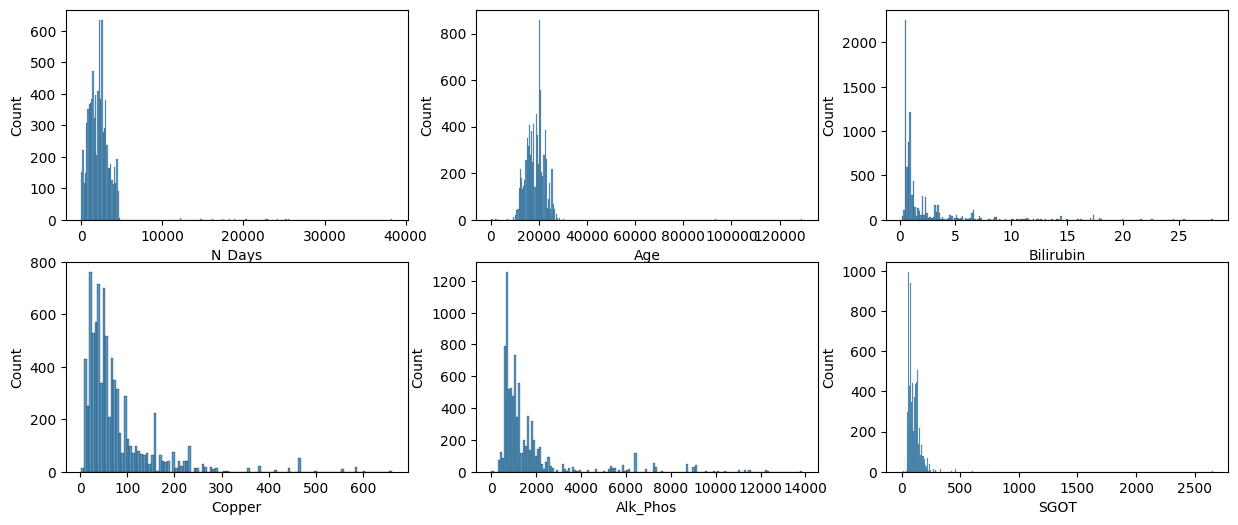

In [33]:
cols_to_vizual = ['N_Days','Age','Bilirubin','Copper','Alk_Phos','SGOT']
fig, ax = plt.subplots(2,3, figsize=(15,6))

sns.histplot(data=df, x='N_Days', ax=ax[0,0])
sns.histplot(data=df, x='Age', ax=ax[0,1])
sns.histplot(data=df, x='Bilirubin', ax=ax[0,2])
sns.histplot(data=df, x='Copper', ax=ax[1,0])
sns.histplot(data=df, x='Alk_Phos', ax=ax[1,1])
sns.histplot(data=df, x='SGOT', ax=ax[1,2])
plt.show()

In [34]:
# noodatiy qiymatni tashlab yuborish
print(df['Status'].value_counts())
idx = df[df['Status']==3.0].index
df = df.drop(idx)

Status
0.0    5675
2.0    2494
1.0     220
3.0       1
Name: count, dtype: int64


#### Yakuniy tahliliy korrelyatsiya

In [35]:
df.corrwith(df['Status']).abs().sort_values(ascending=False)

,0
Status,1.000000
Prothrombin,0.506567
Bilirubin,0.471568
Hepatomegaly,0.434921
Copper,0.419294
Stage,0.382222
Edema,0.353621
Spiders,0.343284
Albumin,0.325769
Ascites,0.315916


In [36]:
print('Tozalangan dataset hajmi qator/ustun:', df.shape)

Tozalangan dataset hajmi qator/ustun: (8389, 15)


## 4.1 Ma'lumotlarni train va test qismlarga ajratish

In [37]:
X = df.drop('Status',axis=1).values
y = df['Status'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)
print("Train_set:", X_train.shape, "Test_set:", X_test.shape)

Train_set: (7550, 14) Test_set: (839, 14)


## 4.2 Train va test ma'lumotlarni normalizatsiyalash

In [38]:
# tahlil
df.describe()

,N_Days,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Prothrombin,Stage,Status
count,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000,8389.000000
mean,2166.181547,18708.400048,0.043867,0.453570,0.202646,0.118846,1.937740,3.588187,75.692574,1618.532316,106.337385,10.621510,3.023722,0.620813
std,1367.407084,3929.074020,0.204811,0.497869,0.401995,0.435177,2.882855,0.366696,74.860129,1768.926994,57.297663,0.775597,0.856702,0.911093
min,14.000000,400.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.500000,2.000000,3.400000,0.900000,9.000000,1.000000,0.000000
25%,1293.000000,16034.000000,0.000000,0.000000,0.000000,0.000000,0.600000,3.370000,31.000000,720.000000,71.000000,10.000000,2.000000,0.000000
50%,2176.000000,19015.000000,0.000000,0.000000,0.000000,0.000000,0.900000,3.610000,52.000000,1072.000000,97.650000,10.600000,3.000000,0.000000
75%,2863.000000,20810.000000,0.000000,1.000000,0.000000,0.000000,2.000000,3.830000,89.000000,1664.000000,130.200000,11.000000,4.000000,2.000000
max,38320.000000,129398.000000,1.000000,1.000000,1.000000,2.000000,28.000000,4.640000,662.000000,13862.400000,2653.000000,17.100000,4.000000,2.000000


In [39]:
# obyekt yaratish va kerakli ustunlarni ajratib olish
scaler = MinMaxScaler()
cols_to_scale = ['N_Days','Age','Bilirubin','Copper','Alk_Phos','SGOT','Prothrombin']

# scale qilinadigan ustunlar indexlarini olish
cols_idx = [df.columns.get_loc(col) for col in cols_to_scale]
print("Scale qilinadigan ustunlar tartib raqamlari:", cols_idx)

X_train[:, cols_idx] = scaler.fit_transform(X_train[:, cols_idx])
X_test[:, cols_idx] = scaler.transform(X_test[:, cols_idx])

Scale qilinadigan ustunlar tartib raqamlari: [0, 1, 7, 9, 10, 11, 12]


## 5.1 Tasniflovchi model qurish
#### *XGBClassifier algoritmdan foydalanildi*

In [41]:
# model parametri uchun eng yaxshi n qiymatni topish
xgb_demo = XGBClassifier()
param_grid = {'n_estimators':np.arange(100)}

xgb_gscv = GridSearchCV(xgb_demo, param_grid=param_grid, cv=5, scoring='neg_log_loss')
xgb_gscv.fit(X_train, y_train)
best_n = xgb_gscv.best_params_['n_estimators']
print('Model parametri uchun eng yaxshi n qiymat:', best_n)

Model parametri uchun eng yaxshi n qiymat: 24


In [42]:
# model yaratish va o'qitish
xgb_model = XGBClassifier(n_estimators=best_n)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=np.int64(24), n_jobs=None, num_parallel_tree=None, ...)

## 5.2 Modelni baholash
### Asosiy metrikalar ko'rsatkichlari va Log Loss hisoblash

In [43]:
predict = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)

print(classification_report(y_test, predict))
print('LOG LOSS:',round(log_loss(y_test, pred_proba),5))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       570
         1.0       0.40      0.11      0.17        19
         2.0       0.83      0.74      0.78       250

    accuracy                           0.86       839
   macro avg       0.70      0.59      0.62       839
weighted avg       0.85      0.86      0.85       839

LOG LOSS: 0.3438


# 6.1 Modelni test toplamda qollash

In [44]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15000 to 24999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         10000 non-null  float64
 1   Drug           5602 non-null   object 
 2   Age            10000 non-null  float64
 3   Sex            10000 non-null  object 
 4   Ascites        5609 non-null   object 
 5   Hepatomegaly   5598 non-null   object 
 6   Spiders        5596 non-null   object 
 7   Edema          10000 non-null  object 
 8   Bilirubin      10000 non-null  float64
 9   Cholesterol    4353 non-null   float64
 10  Albumin        10000 non-null  float64
 11  Copper         5531 non-null   float64
 12  Alk_Phos       5597 non-null   float64
 13  SGOT           5594 non-null   float64
 14  Tryglicerides  4320 non-null   float64
 15  Platelets      9618 non-null   float64
 16  Prothrombin    9991 non-null   float64
 17  Stage          10000 non-null  float64
dtypes: floa

In [45]:
# kategoriyali ustunlarni raqamlashtirish

test_set['Status'] = 'D'   # encoder obyekt shu ustun bilan fit qilingan | vaqtinchalik ustun
test_set['Sex'] = test_set['Sex'].map({'F':0.0,'M':1.0})  # Sex ustuniga .map() bilan ishlov berish

test_set[cols_to_encode] = encoder.transform(test_set[cols_to_encode])
test_set = test_set.drop('Status', axis=1)

In [46]:
# karrelyatsiya past ustunlarni tashlab yuborish
test_set = test_set.drop(low_corr_columns, axis=1)
test_set = test_set.drop('Platelets', axis=1)

In [47]:
# NaN mavjud qatorlarni tashlab yuborish
test_set = test_set.dropna()

In [48]:
# NaN qiymatlar tahlili
test_set.isnull().sum()

,0
N_Days,0
Age,0
Sex,0
Ascites,0
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0
Albumin,0
Copper,0


In [49]:
display(test_set.describe())
print('\nNormalizatsiya qilinadigan ustunlar nomlari: ', cols_to_scale)
print('Yuqoridagi ustunlar indexlari: ', cols_idx)

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Prothrombin,Stage
count,5528.000000,5528.00000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000
mean,2177.471056,18800.43759,0.043958,0.048300,0.456585,0.205680,0.124096,1.984352,3.586673,74.714658,1638.844700,109.269863,10.633321,3.016462
std,1390.118432,3631.02664,0.205020,0.214418,0.498157,0.404234,0.445485,3.174286,0.378217,72.529349,1831.156283,255.112581,0.797089,0.880143
min,41.000000,400.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,1.200000,4.000000,8.100000,12.350000,9.000000,1.000000
25%,1295.000000,16109.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,3.370000,31.000000,704.750000,70.000000,10.000000,2.000000
50%,2176.000000,19155.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.900000,3.620000,52.000000,1062.000000,96.100000,10.600000,3.000000
75%,2863.000000,20891.00000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,3.830000,89.000000,1644.000000,130.200000,11.000000,4.000000
max,25568.000000,28650.00000,1.000000,1.000000,1.000000,1.000000,2.000000,37.400000,4.640000,588.000000,18393.000000,18628.000000,18.000000,4.000000



Normalizatsiya qilinadigan ustunlar nomlari:  ['N_Days', 'Age', 'Bilirubin', 'Copper', 'Alk_Phos', 'SGOT', 'Prothrombin']
Yuqoridagi ustunlar indexlari:  [0, 1, 7, 9, 10, 11, 12]


In [50]:
# qiymatlarni normalizatsiyalash
test_set[cols_to_scale] = scaler.transform(test_set.values[:, cols_idx])
indexs = test_set.index

In [51]:
# normalizatsiya tahlili
test_set.describe()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Prothrombin,Stage
count,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000,5528.000000
mean,0.056479,0.142641,0.043958,0.048300,0.456585,0.205680,0.124096,0.064185,3.586673,0.124086,0.118006,0.040862,0.201645,3.016462
std,0.036290,0.028148,0.205020,0.214418,0.498157,0.404234,0.445485,0.114183,0.378217,0.123770,0.132128,0.096193,0.098406,0.880143
min,0.000705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003597,1.200000,0.003413,0.000339,0.004317,0.000000,1.000000
25%,0.033441,0.121777,0.000000,0.000000,0.000000,0.000000,0.000000,0.014388,3.370000,0.049488,0.050606,0.026055,0.123457,2.000000
50%,0.056440,0.145390,0.000000,0.000000,0.000000,0.000000,0.000000,0.025180,3.620000,0.085324,0.076384,0.035896,0.197531,3.000000
75%,0.074375,0.158847,0.000000,0.000000,1.000000,0.000000,0.000000,0.064748,3.830000,0.148464,0.118378,0.048754,0.246914,4.000000
max,0.667102,0.218996,1.000000,1.000000,1.000000,1.000000,2.000000,1.338129,4.640000,1.000000,1.326907,7.023529,1.111111,4.000000


In [52]:
predict_proba = xgb_model.predict_proba(test_set)
print("Kategoriyalar tartibi:", xgb_model.classes_)

Kategoriyalar tartibi: [0 1 2]


### Bashoratlar ehtimolliklari

In [53]:
columns = ['Status_C','Status_CL','Status_D']
results_df = pd.DataFrame(predict_proba, index=indexs, columns=columns)

results_df

,Status_C,Status_CL,Status_D
id,,,
15002,0.625689,0.011596,0.362715
15003,0.974346,0.001547,0.024108
15005,0.724760,0.006666,0.268574
15006,0.101651,0.005624,0.892725
15007,0.006926,0.002964,0.990109
...,...,...,...
24994,0.042883,0.024609,0.932508
24995,0.915007,0.075764,0.009229
24996,0.198956,0.012399,0.788645


### Natijalarni .csv filega saqlab olish

In [56]:
results_df.to_csv('submissons.csv')